<a href="https://colab.research.google.com/github/RickeyEstes/AI-Stock-Experiment/blob/main/Stock_Screener_jpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install bs4
!pip install requests
!pip install ta
!pip install finta
!pip install mplfinance
import pandas as pd
import requests
from datetime import datetime
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import math
import mplfinance as mpf

In [ ]:
screened_list = []
stock_list = ['RTX','TSLA','MSFT','AMZN']
for stock_code in stock_list:
  # get stock prices
  df = yf.download(stock_code, start='2020-01-01', threads= False)
  # parameter setup
  length = 20
  mult = 2
  length_KC = 20
  mult_KC = 1.5
  # calculate BB
  m_avg = df['Close'].rolling(window=length).mean()
  m_std = df['Close'].rolling(window=length).std(ddof=0)
  df['upper_BB'] = m_avg + mult * m_std
  df['lower_BB'] = m_avg - mult * m_std
  # calculate true range
  df['tr0'] = abs(df["High"] - df["Low"])
  df['tr1'] = abs(df["High"] - df["Close"].shift())
  df['tr2'] = abs(df["Low"] - df["Close"].shift())
  df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
  # calculate KC
  range_ma = df['tr'].rolling(window=length_KC).mean()
  df['upper_KC'] = m_avg + range_ma * mult_KC
  df['lower_KC'] = m_avg - range_ma * mult_KC
  # calculate bar value
  highest = df['High'].rolling(window = length_KC).max()
  lowest = df['Low'].rolling(window = length_KC).min()
  m1 = (highest + lowest)/2
  df['value'] = (df['Close'] - (m1 + m_avg)/2)
  fit_y = np.array(range(0,length_KC))
  df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                            np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                            np.polyfit(fit_y, x, 1)[1], raw=True)
  # check for 'squeeze'
  df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
  df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])
  # buying window for long position:
  # 1. black cross becomes gray (the squeeze is released)
  long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
  # 2. bar value is positive => the bar is light green k
  long_cond2 = df['value'][-1] > 0
  enter_long = long_cond1 and long_cond2
  # buying window for short position:
  # 1. black cross becomes gray (the squeeze is released)
  short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
  # 2. bar value is negative => the bar is light red 
  short_cond2 = df['value'][-1] < 0
  enter_short = short_cond1 and short_cond2
  if enter_long | enter_short:
      screened_list.append(stock_code)
if screened_list:
  print(screened_list)
else:
  print('No stock fits the Squeeze Momentum Indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
No stock fits the Squeeze Momentum Indicator entry requirement


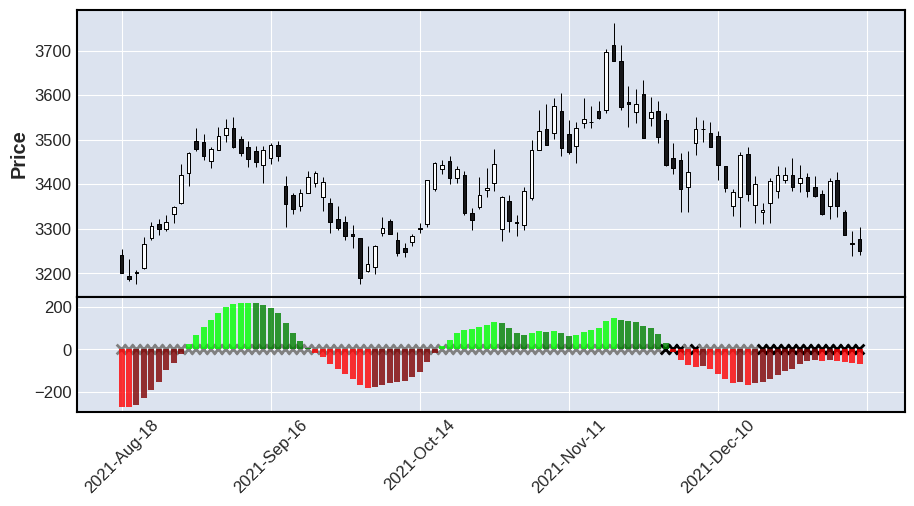

In [ ]:
# to make the visualization better by only taking the last 100 rows of data
df = df[-100:]
# extract only ['Open', 'High', 'Close', 'Low'] from df
ohcl = df[['Open', 'High', 'Close', 'Low']]
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df['value']):
  if val >= 0:
    color = 'green'
    if val > df['value'][ind-1]:
      color = 'lime'
  else:
    color = 'maroon'
    if val < df['value'][ind-1]:
      color='red'
  colors.append(color)
  
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in df['squeeze_off']], secondary_y=False)]
# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1, 
              type='candle', 
              addplot=apds,
              returnfig=True)